Multiview Training. Co-training. Democratic co-traning.


#Мета
Ознайомлення з ідеями багатовидового навчання(multiview  training). Отримання практичних навичок роботи з алгоритмами багатовидового навчання з застосуванням технологій напівкерованого навчання



#Хід роботи

## 1. Виконання налаштування робочого середовища

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

## 2. Завантаження набору даних MNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 143089198.18it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 40405501.61it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29649742.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17162638.53it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## 3. Відобразимо декілька зображень з набору даних


In [ ]:
class_names = trainset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

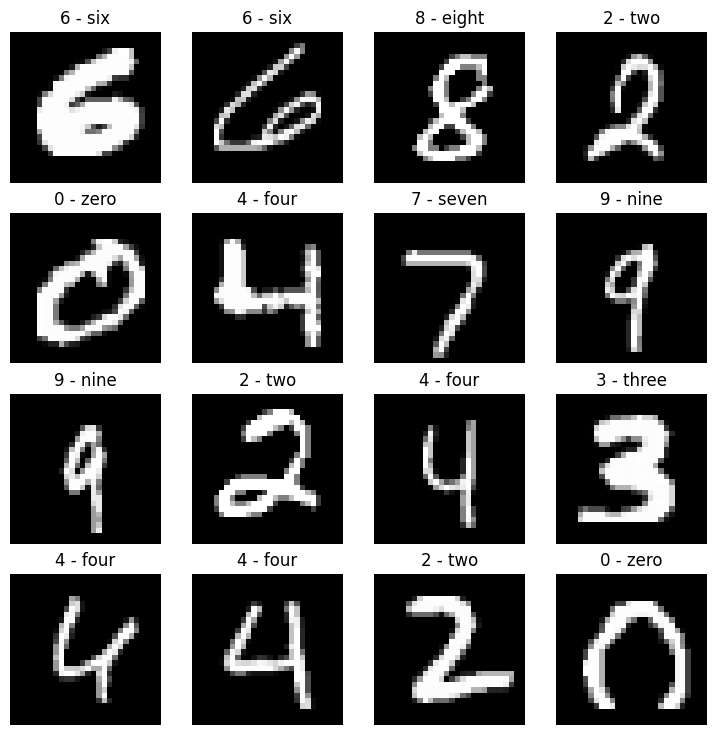

In [ ]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 4. Розділимо  набір даних на три вибірки: тренувальну та валідаційну

In [ ]:
# Divide the dataset into training, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
full_train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [ ]:
label_size = int(0.3 * len(full_train_dataset))
unlabel_size = len(full_train_dataset) - label_size
label_dataset, unlabel_dataset = torch.utils.data.random_split(full_train_dataset, [label_size, unlabel_size])

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(full_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = DataLoader(val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

label_dataloader = DataLoader(label_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

unlabel_dataloader = DataLoader(unlabel_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Full train images: {len(train_dataloader) * BATCH_SIZE}")
print(f"Label images: {len(label_dataloader)* BATCH_SIZE}")
print(f"Unlabel images: {len(unlabel_dataloader)* BATCH_SIZE}")
print(f"Valid images: {len(valid_dataloader)* BATCH_SIZE}")
print(f"Test images: {len(test_dataloader)* BATCH_SIZE}")

Full train images: 48000
Label images: 14400
Unlabel images: 33600
Valid images: 12000
Test images: 10016


In [ ]:
class_counts = {i: 0 for i in range(10)}
for images, labels in label_dataloader:
    for label in labels:
        class_counts[label.item()] += 1

# Print the counts
for label, count in class_counts.items():
    print(f"Class {label}: {count} images")

Class 0: 1440 images
Class 1: 1632 images
Class 2: 1359 images
Class 3: 1444 images
Class 4: 1392 images
Class 5: 1287 images
Class 6: 1437 images
Class 7: 1550 images
Class 8: 1377 images
Class 9: 1482 images


## 5. Завантажимо та налаштуємо нейронну мережу

In [ ]:
class ClassifierCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ClassifierCNN, self).__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32*12*12,
                      out_features=num_classes)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.classifier(x)
        return torch.softmax(x, dim=1)

In [ ]:
from typing import Dict, List

# Training loop
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          valid_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
             "train_acc": [],
             "val_loss": [],
             "val_acc": []
             }

  for epoch in range(epochs):
      # Training
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in tqdm(train_dataloader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_dataloader)
      train_acc = 100 * correct_train / total_train

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)

      # Validation
      model.eval()
      running_loss = 0.0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
          for inputs, labels in valid_dataloader:
              inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)
              running_loss += loss.item()

              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_loss = running_loss / len(valid_dataloader)
      val_acc = 100 * correct_val / total_val

      results["val_loss"].append(val_loss)
      results["val_acc"].append(val_acc)

      print(f"Epoch [{epoch + 1}/{epochs}] - "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}% - "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

  return results

In [ ]:
def plot_model(history):
  train_accs, val_accs, train_losses, val_losses = history
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(history['train_acc'], label='Train')
  plt.plot(history['val_acc'], label='Validation')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history['train_loss'], label='Train')
  plt.plot(history['val_loss'], label='Validation')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

## 6. Проведемо навчання нейронної мережі на початковому (до розділу на маркований і немаркований) тренувальному наборі даних.

In [ ]:
model_net = ClassifierCNN(num_classes=10).to(device)

summary(model=model_net,
        input_size=(32, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ClassifierCNN (ClassifierCNN)            [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (block_1)                   [32, 1, 28, 28]      [32, 32, 12, 12]     --                   True
│    └─Conv2d (0)                        [32, 1, 28, 28]      [32, 32, 26, 26]     320                  True
│    └─ReLU (1)                          [32, 32, 26, 26]     [32, 32, 26, 26]     --                   --
│    └─Conv2d (2)                        [32, 32, 26, 26]     [32, 32, 24, 24]     9,248                True
│    └─ReLU (3)                          [32, 32, 24, 24]     [32, 32, 24, 24]     --                   --
│    └─MaxPool2d (4)                     [32, 32, 24, 24]     [32, 32, 12, 12]     --                   --
├─Sequential (classifier)                [32, 32, 12, 12]     [32, 10]             --                   True
│    └─Flatten (0)  

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_net.parameters(), lr=0.001)

results = train(model=model_net,
                train_dataloader=train_dataloader,
                valid_dataloader=valid_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=20,
                device=device)

100%|██████████| 1500/1500 [00:15<00:00, 96.14it/s] 


Epoch [1/20] - Train Loss: 1.5221, Train Accuracy: 94.34% - Validation Loss: 1.4924, Validation Accuracy: 96.90%


100%|██████████| 1500/1500 [00:14<00:00, 101.55it/s]


Epoch [2/20] - Train Loss: 1.4841, Train Accuracy: 97.76% - Validation Loss: 1.4836, Validation Accuracy: 97.78%


100%|██████████| 1500/1500 [00:14<00:00, 100.25it/s]


Epoch [3/20] - Train Loss: 1.4800, Train Accuracy: 98.17% - Validation Loss: 1.4836, Validation Accuracy: 97.76%


100%|██████████| 1500/1500 [00:14<00:00, 101.83it/s]


Epoch [4/20] - Train Loss: 1.4778, Train Accuracy: 98.34% - Validation Loss: 1.4797, Validation Accuracy: 98.17%


100%|██████████| 1500/1500 [00:17<00:00, 83.79it/s] 


Epoch [5/20] - Train Loss: 1.4765, Train Accuracy: 98.48% - Validation Loss: 1.4808, Validation Accuracy: 98.05%


100%|██████████| 1500/1500 [00:16<00:00, 92.27it/s] 


Epoch [6/20] - Train Loss: 1.4745, Train Accuracy: 98.68% - Validation Loss: 1.4779, Validation Accuracy: 98.31%


100%|██████████| 1500/1500 [00:14<00:00, 101.71it/s]


Epoch [7/20] - Train Loss: 1.4736, Train Accuracy: 98.78% - Validation Loss: 1.4790, Validation Accuracy: 98.21%


100%|██████████| 1500/1500 [00:15<00:00, 98.77it/s]


Epoch [8/20] - Train Loss: 1.4734, Train Accuracy: 98.79% - Validation Loss: 1.4785, Validation Accuracy: 98.27%


100%|██████████| 1500/1500 [00:14<00:00, 100.58it/s]


Epoch [9/20] - Train Loss: 1.4721, Train Accuracy: 98.90% - Validation Loss: 1.4766, Validation Accuracy: 98.44%


100%|██████████| 1500/1500 [00:15<00:00, 99.52it/s] 


Epoch [10/20] - Train Loss: 1.4719, Train Accuracy: 98.92% - Validation Loss: 1.4799, Validation Accuracy: 98.12%


100%|██████████| 1500/1500 [00:15<00:00, 98.32it/s]


Epoch [11/20] - Train Loss: 1.4711, Train Accuracy: 99.02% - Validation Loss: 1.4773, Validation Accuracy: 98.42%


100%|██████████| 1500/1500 [00:14<00:00, 101.57it/s]


Epoch [12/20] - Train Loss: 1.4707, Train Accuracy: 99.05% - Validation Loss: 1.4794, Validation Accuracy: 98.14%


100%|██████████| 1500/1500 [00:15<00:00, 99.36it/s] 


Epoch [13/20] - Train Loss: 1.4717, Train Accuracy: 98.94% - Validation Loss: 1.4777, Validation Accuracy: 98.34%


100%|██████████| 1500/1500 [00:15<00:00, 99.06it/s]


Epoch [14/20] - Train Loss: 1.4708, Train Accuracy: 99.04% - Validation Loss: 1.4770, Validation Accuracy: 98.38%


100%|██████████| 1500/1500 [00:14<00:00, 100.22it/s]


Epoch [15/20] - Train Loss: 1.4706, Train Accuracy: 99.05% - Validation Loss: 1.4755, Validation Accuracy: 98.58%


100%|██████████| 1500/1500 [00:14<00:00, 100.55it/s]


Epoch [16/20] - Train Loss: 1.4698, Train Accuracy: 99.13% - Validation Loss: 1.4784, Validation Accuracy: 98.28%


100%|██████████| 1500/1500 [00:14<00:00, 100.80it/s]


Epoch [17/20] - Train Loss: 1.4704, Train Accuracy: 99.08% - Validation Loss: 1.4766, Validation Accuracy: 98.47%


100%|██████████| 1500/1500 [00:15<00:00, 99.01it/s]


Epoch [18/20] - Train Loss: 1.4691, Train Accuracy: 99.20% - Validation Loss: 1.4772, Validation Accuracy: 98.37%


100%|██████████| 1500/1500 [00:14<00:00, 100.10it/s]


Epoch [19/20] - Train Loss: 1.4693, Train Accuracy: 99.19% - Validation Loss: 1.4763, Validation Accuracy: 98.47%


100%|██████████| 1500/1500 [00:15<00:00, 98.75it/s] 


Epoch [20/20] - Train Loss: 1.4682, Train Accuracy: 99.29% - Validation Loss: 1.4764, Validation Accuracy: 98.46%


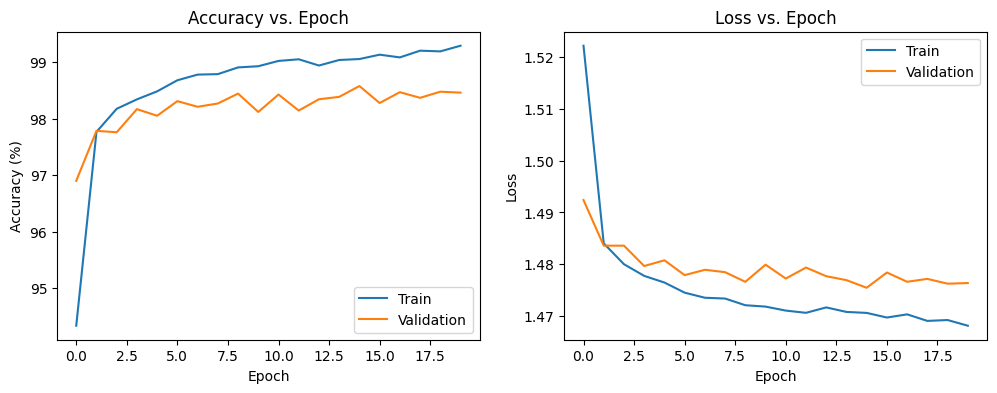

In [ ]:
plot_model(results)

## 7. Збережемо ваги навченої нейронної мережі у файл

In [ ]:
torch.save(model_net.state_dict(), 'full_data_train.pth')

## 8. Провести навчання нейронної мережі напівкерованим алгоритмом використовуючи маркований і немаркований набір даних на 4 кроці.

In [ ]:
# Define the custom dataset to include pseudo-labels
class CombineDataset(Dataset):
    def __init__(self, labeled_dataset, unlabeled_dataset, pseudo_labels):
        self.labeled_dataset = labeled_dataset
        self.unlabeled_dataset = unlabeled_dataset
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.labeled_dataset) + len(self.unlabeled_dataset)

    def __getitem__(self, index):
        if index < len(self.labeled_dataset):
            return self.labeled_dataset[index]
        else:
            # Adjust the index for the unlabeled data
            unlabeled_index = index - len(self.labeled_dataset)
            unlabeled_data, _ = self.unlabeled_dataset[unlabeled_index]
            pseudo_label = self.pseudo_labels[unlabeled_index]
            return unlabeled_data, pseudo_label

In [ ]:
from typing import Dict, List

# Training loop
def co_train(model1: torch.nn.Module,
             model2: torch.nn.Module,
             label_dataloader: torch.utils.data.DataLoader,
             unlabel_dataloader: torch.utils.data.DataLoader,
             valid_dataloader: torch.utils.data.DataLoader,
             optimizer1: torch.optim.Optimizer,
             optimizer2: torch.optim.Optimizer,
             loss_fn: torch.nn.Module,
             epochs: int,
             device: torch.device) -> Dict[str, List]:



    results = {"train_loss1": [],
              "train_acc1": [],
              "train_loss2": [],
              "train_acc2": [],
              "pseudo_loss1":[],
              "pseudo_acc1": [],
              "pseudo_loss2": [],
              "pseudo_acc2": [],
              "val_loss1": [],
              "val_acc1": [],
              "val_loss2": [],
              "val_acc2": []
              }

    # Training the models using co-training
    for epoch in range(epochs):
        model1.train()
        model2.train()

        running_loss1 = 0.0
        running_loss2 = 0.0
        correct_train1 = 0
        correct_train2 = 0
        total_train1 = 0
        total_train2 = 0

        print(f"Epoch [{epoch + 1}/{epochs}]")
        for labeled_data, labels in tqdm(label_dataloader):
            labeled_data, labels = labeled_data.to(device), labels.to(device)
            optimizer1.zero_grad()
            optimizer2.zero_grad()

            # Train model1 with labeled data
            outputs1 = model1(labeled_data)
            loss1 = loss_fn(outputs1, labels)
            loss1.backward()
            optimizer1.step()

            # Train model2 with labeled data
            outputs2 = model2(labeled_data)
            loss2 = loss_fn(outputs2, labels)
            loss2.backward()
            optimizer2.step()

            running_loss1 += loss1.item()
            running_loss2 += loss2.item()

            _, predicted1 = torch.max(outputs1, 1)
            _, predicted2 = torch.max(outputs2, 1)

            total_train1 += labels.size(0)
            total_train2 += labels.size(0)

            correct_train1 += (predicted1 == labels).sum().item()
            correct_train2 += (predicted2 == labels).sum().item()

        train_loss1 = running_loss1 / len(label_dataloader)
        train_loss2 = running_loss2 / len(label_dataloader)

        train_acc1 = 100 * correct_train1 / total_train1
        train_acc2 = 100 * correct_train2 / total_train2

        results["train_loss1"].append(train_loss1)
        results["train_acc1"].append(train_acc1)
        results["train_loss2"].append(train_loss2)
        results["train_acc2"].append(train_acc2)

        # Pseudo-label unlabeled data
        model1.eval()
        model2.eval()

        pseudo_labels1 = []
        pseudo_labels2 = []

        for data_unlabeled, _ in unlabel_dataloader:
            with torch.no_grad():
                data_unlabeled = data_unlabeled.to(device)
                outputs1 = model1(data_unlabeled)
                outputs2 = model2(data_unlabeled)
                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                pseudo_labels1.extend(predicted1.tolist())
                pseudo_labels2.extend(predicted2.tolist())

        # Concatenate the labeled and unlabeled data using the custom dataset
        combined_dataset1 = CombineDataset(label_dataset, unlabel_dataset, pseudo_labels1)
        combined_dataset2 = CombineDataset(label_dataset, unlabel_dataset, pseudo_labels2)

        combined_dataloader1 = DataLoader(combined_dataset1, batch_size=BATCH_SIZE, shuffle=True)
        combined_dataloader2 = DataLoader(combined_dataset2, batch_size=BATCH_SIZE, shuffle=True)

        model1.train()
        model2.train()
        running_loss1 = 0.0
        running_loss2 = 0.0
        correct_train1 = 0
        correct_train2 = 0
        total_train = 0

        for (data1, labels1), (data2, labels2) in tqdm(zip(combined_dataloader1, combined_dataloader2)):
            data1, labels1 = data1.to(device), labels1.to(device)
            data2, labels2 = data2.to(device), labels2.to(device)

            # Train the first view model on combine dataset from second view model
            optimizer1.zero_grad()
            outputs1 = model1(data2)
            loss1 = loss_fn(outputs1, labels2)
            loss1.backward()
            optimizer1.step()

            running_loss1 += loss1.item()
            _, predicted = torch.max(outputs1.data, 1)
            total_train += labels2.size(0)
            correct_train1 += (predicted == labels2).sum().item()

            # Train the second view model on combine dataset from first view model
            optimizer2.zero_grad()
            outputs2 = model2(data1)
            loss2 = loss_fn(outputs2, labels1)
            loss2.backward()
            optimizer2.step()

            running_loss2 += loss2.item()
            _, predicted = torch.max(outputs2.data, 1)
            correct_train2 += (predicted == labels1).sum().item()

        pseudo_loss1 = running_loss1 / len(combined_dataloader1)
        pseudo_loss2 = running_loss2 / len(combined_dataloader2)

        pseudo_acc1 = 100 * correct_train1 / total_train
        pseudo_acc2 = 100 * correct_train2 / total_train

        results["pseudo_loss1"].append(pseudo_loss1)
        results["pseudo_acc1"].append(pseudo_acc1)
        results["pseudo_loss2"].append(pseudo_loss2)
        results["pseudo_acc2"].append(pseudo_acc2)

        # Validation
        model1.eval()
        model2.eval()
        running_loss1 = 0.0
        running_loss2 = 0.0
        correct_val1 = 0
        correct_val2 = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valid_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs1 = model1(inputs)
                outputs2 = model2(inputs)
                loss1 = loss_fn(outputs1, labels)
                loss2 = loss_fn(outputs2, labels)
                running_loss1 += loss1.item()
                running_loss2 += loss2.item()

                _, predicted1 = torch.max(outputs1.data, 1)
                _, predicted2 = torch.max(outputs2.data, 1)
                total_val += labels.size(0)
                correct_val1 += (predicted1 == labels).sum().item()
                correct_val2 += (predicted2 == labels).sum().item()

        val_loss1 = running_loss1 / len(valid_dataloader)
        val_loss2 = running_loss2 / len(valid_dataloader)
        val_acc1 = 100 * correct_val1 / total_val
        val_acc2 = 100 * correct_val2 / total_val

        results["val_loss1"].append(val_loss1)
        results["val_acc1"].append(val_acc1)
        results["val_loss2"].append(val_loss2)
        results["val_acc2"].append(val_acc2)

        print(f"Model 1: Train: Loss: {train_loss1:.4f}, Accuracy: {train_acc1:.2f}% - "
              f"Pseudo train: Loss: {pseudo_loss1:.4f}, Accuracy: {pseudo_acc1:.2f}% - "
              f"Validation: Loss: {val_loss1:.4f}, Accuracy: {val_acc1:.2f}%")
        print(f"Model 2: Train: Loss: {train_loss2:.4f}, Accuracy: {train_acc2:.2f}% - "
              f"Pseudo train: Loss: {pseudo_loss2:.4f}, Accuracy: {pseudo_acc2:.2f}% - "
              f"Validation: Loss: {val_loss2:.4f}, Accuracy: {val_acc2:.2f}%")

    return results

In [ ]:
model_net1 = ClassifierCNN(num_classes=10).to(device)
model_net2 = ClassifierCNN(num_classes=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model_net1.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model_net2.parameters(), lr=0.001)

results = co_train(model1=model_net1,
                   model2=model_net2,
                   label_dataloader=label_dataloader,
                   unlabel_dataloader=unlabel_dataloader,
                   valid_dataloader=valid_dataloader,
                   optimizer1=optimizer1,
                   optimizer2=optimizer2,
                   loss_fn=loss_fn,
                   epochs=20,
                   device=device)

Epoch [1/20]


100%|██████████| 450/450 [00:05<00:00, 88.72it/s]
1500it [00:30, 49.19it/s]


Model 1: Train: Loss: 1.5853, Accuracy: 88.48% - Pseudo train: Loss: 1.4995, Accuracy: 96.24% - Validation: Loss: 1.5089, Accuracy: 95.19%
Model 2: Train: Loss: 1.5941, Accuracy: 87.49% - Pseudo train: Loss: 1.5015, Accuracy: 96.07% - Validation: Loss: 1.5059, Accuracy: 95.57%
Epoch [2/20]


100%|██████████| 450/450 [00:05<00:00, 77.42it/s]
1500it [00:30, 49.22it/s]


Model 1: Train: Loss: 1.4945, Accuracy: 96.62% - Pseudo train: Loss: 1.4858, Accuracy: 97.55% - Validation: Loss: 1.4962, Accuracy: 96.47%
Model 2: Train: Loss: 1.4924, Accuracy: 96.90% - Pseudo train: Loss: 1.4873, Accuracy: 97.41% - Validation: Loss: 1.4959, Accuracy: 96.52%
Epoch [3/20]


100%|██████████| 450/450 [00:05<00:00, 87.82it/s]
1500it [00:29, 50.43it/s]


Model 1: Train: Loss: 1.4835, Accuracy: 97.78% - Pseudo train: Loss: 1.4820, Accuracy: 97.93% - Validation: Loss: 1.4953, Accuracy: 96.56%
Model 2: Train: Loss: 1.4869, Accuracy: 97.47% - Pseudo train: Loss: 1.4819, Accuracy: 97.95% - Validation: Loss: 1.4922, Accuracy: 96.89%
Epoch [4/20]


100%|██████████| 450/450 [00:05<00:00, 75.70it/s]
1500it [00:31, 47.46it/s]


Model 1: Train: Loss: 1.4808, Accuracy: 98.06% - Pseudo train: Loss: 1.4809, Accuracy: 98.04% - Validation: Loss: 1.4919, Accuracy: 96.87%
Model 2: Train: Loss: 1.4809, Accuracy: 98.03% - Pseudo train: Loss: 1.4824, Accuracy: 97.87% - Validation: Loss: 1.4903, Accuracy: 97.03%
Epoch [5/20]


100%|██████████| 450/450 [00:05<00:00, 87.78it/s]
1500it [00:29, 50.32it/s]


Model 1: Train: Loss: 1.4772, Accuracy: 98.40% - Pseudo train: Loss: 1.4782, Accuracy: 98.32% - Validation: Loss: 1.4853, Accuracy: 97.53%
Model 2: Train: Loss: 1.4797, Accuracy: 98.15% - Pseudo train: Loss: 1.4784, Accuracy: 98.27% - Validation: Loss: 1.4841, Accuracy: 97.69%
Epoch [6/20]


100%|██████████| 450/450 [00:05<00:00, 82.54it/s]
1500it [00:29, 50.53it/s]


Model 1: Train: Loss: 1.4753, Accuracy: 98.61% - Pseudo train: Loss: 1.4770, Accuracy: 98.40% - Validation: Loss: 1.4858, Accuracy: 97.53%
Model 2: Train: Loss: 1.4750, Accuracy: 98.63% - Pseudo train: Loss: 1.4772, Accuracy: 98.37% - Validation: Loss: 1.4845, Accuracy: 97.67%
Epoch [7/20]


100%|██████████| 450/450 [00:05<00:00, 82.15it/s]
1500it [00:30, 49.80it/s]


Model 1: Train: Loss: 1.4746, Accuracy: 98.66% - Pseudo train: Loss: 1.4767, Accuracy: 98.46% - Validation: Loss: 1.4872, Accuracy: 97.39%
Model 2: Train: Loss: 1.4753, Accuracy: 98.58% - Pseudo train: Loss: 1.4762, Accuracy: 98.48% - Validation: Loss: 1.4875, Accuracy: 97.32%
Epoch [8/20]


100%|██████████| 450/450 [00:05<00:00, 87.21it/s]
1500it [00:29, 50.77it/s]


Model 1: Train: Loss: 1.4744, Accuracy: 98.64% - Pseudo train: Loss: 1.4765, Accuracy: 98.46% - Validation: Loss: 1.4871, Accuracy: 97.40%
Model 2: Train: Loss: 1.4741, Accuracy: 98.68% - Pseudo train: Loss: 1.4762, Accuracy: 98.50% - Validation: Loss: 1.4863, Accuracy: 97.45%
Epoch [9/20]


100%|██████████| 450/450 [00:05<00:00, 76.99it/s]
1500it [00:30, 49.84it/s]


Model 1: Train: Loss: 1.4722, Accuracy: 98.90% - Pseudo train: Loss: 1.4762, Accuracy: 98.49% - Validation: Loss: 1.4847, Accuracy: 97.61%
Model 2: Train: Loss: 1.4726, Accuracy: 98.85% - Pseudo train: Loss: 1.4755, Accuracy: 98.56% - Validation: Loss: 1.4871, Accuracy: 97.41%
Epoch [10/20]


100%|██████████| 450/450 [00:06<00:00, 64.43it/s]
1500it [00:30, 48.69it/s]


Model 1: Train: Loss: 1.4725, Accuracy: 98.84% - Pseudo train: Loss: 1.4745, Accuracy: 98.66% - Validation: Loss: 1.4862, Accuracy: 97.49%
Model 2: Train: Loss: 1.4724, Accuracy: 98.88% - Pseudo train: Loss: 1.4750, Accuracy: 98.62% - Validation: Loss: 1.4826, Accuracy: 97.85%
Epoch [11/20]


100%|██████████| 450/450 [00:05<00:00, 78.69it/s]
1500it [00:34, 43.38it/s]


Model 1: Train: Loss: 1.4712, Accuracy: 98.99% - Pseudo train: Loss: 1.4726, Accuracy: 98.84% - Validation: Loss: 1.4830, Accuracy: 97.82%
Model 2: Train: Loss: 1.4713, Accuracy: 98.99% - Pseudo train: Loss: 1.4739, Accuracy: 98.71% - Validation: Loss: 1.4836, Accuracy: 97.76%
Epoch [12/20]


100%|██████████| 450/450 [00:08<00:00, 56.19it/s]
1500it [00:30, 49.38it/s]


Model 1: Train: Loss: 1.4716, Accuracy: 98.98% - Pseudo train: Loss: 1.4749, Accuracy: 98.62% - Validation: Loss: 1.4871, Accuracy: 97.40%
Model 2: Train: Loss: 1.4714, Accuracy: 98.98% - Pseudo train: Loss: 1.4747, Accuracy: 98.62% - Validation: Loss: 1.4846, Accuracy: 97.67%
Epoch [13/20]


100%|██████████| 450/450 [00:05<00:00, 87.52it/s]
1500it [00:37, 39.58it/s]


Model 1: Train: Loss: 1.4709, Accuracy: 99.04% - Pseudo train: Loss: 1.4739, Accuracy: 98.73% - Validation: Loss: 1.4838, Accuracy: 97.71%
Model 2: Train: Loss: 1.4717, Accuracy: 98.94% - Pseudo train: Loss: 1.4726, Accuracy: 98.85% - Validation: Loss: 1.4834, Accuracy: 97.76%
Epoch [14/20]


100%|██████████| 450/450 [00:07<00:00, 59.60it/s]
1500it [00:40, 37.10it/s]


Model 1: Train: Loss: 1.4706, Accuracy: 99.06% - Pseudo train: Loss: 1.4733, Accuracy: 98.78% - Validation: Loss: 1.4822, Accuracy: 97.90%
Model 2: Train: Loss: 1.4712, Accuracy: 98.99% - Pseudo train: Loss: 1.4741, Accuracy: 98.70% - Validation: Loss: 1.4862, Accuracy: 97.49%
Epoch [15/20]


100%|██████████| 450/450 [00:06<00:00, 71.87it/s]
1500it [00:32, 46.18it/s]


Model 1: Train: Loss: 1.4698, Accuracy: 99.13% - Pseudo train: Loss: 1.4733, Accuracy: 98.78% - Validation: Loss: 1.4831, Accuracy: 97.78%
Model 2: Train: Loss: 1.4723, Accuracy: 98.88% - Pseudo train: Loss: 1.4725, Accuracy: 98.86% - Validation: Loss: 1.4815, Accuracy: 97.97%
Epoch [16/20]


100%|██████████| 450/450 [00:05<00:00, 86.85it/s]
1500it [00:31, 47.19it/s]


Model 1: Train: Loss: 1.4703, Accuracy: 99.08% - Pseudo train: Loss: 1.4710, Accuracy: 99.03% - Validation: Loss: 1.4813, Accuracy: 97.97%
Model 2: Train: Loss: 1.4688, Accuracy: 99.24% - Pseudo train: Loss: 1.4724, Accuracy: 98.88% - Validation: Loss: 1.4827, Accuracy: 97.83%
Epoch [17/20]


100%|██████████| 450/450 [00:05<00:00, 78.54it/s]
1500it [00:40, 37.26it/s]


Model 1: Train: Loss: 1.4699, Accuracy: 99.13% - Pseudo train: Loss: 1.4722, Accuracy: 98.89% - Validation: Loss: 1.4833, Accuracy: 97.78%
Model 2: Train: Loss: 1.4704, Accuracy: 99.06% - Pseudo train: Loss: 1.4725, Accuracy: 98.87% - Validation: Loss: 1.4819, Accuracy: 97.92%
Epoch [18/20]


100%|██████████| 450/450 [00:06<00:00, 70.58it/s]
1500it [00:40, 36.81it/s]


Model 1: Train: Loss: 1.4696, Accuracy: 99.15% - Pseudo train: Loss: 1.4738, Accuracy: 98.75% - Validation: Loss: 1.4839, Accuracy: 97.72%
Model 2: Train: Loss: 1.4700, Accuracy: 99.11% - Pseudo train: Loss: 1.4720, Accuracy: 98.91% - Validation: Loss: 1.4859, Accuracy: 97.52%
Epoch [19/20]


100%|██████████| 450/450 [00:05<00:00, 80.72it/s]
1500it [00:35, 42.25it/s]


Model 1: Train: Loss: 1.4695, Accuracy: 99.16% - Pseudo train: Loss: 1.4732, Accuracy: 98.79% - Validation: Loss: 1.4840, Accuracy: 97.72%
Model 2: Train: Loss: 1.4719, Accuracy: 98.93% - Pseudo train: Loss: 1.4713, Accuracy: 98.98% - Validation: Loss: 1.4820, Accuracy: 97.88%
Epoch [20/20]


100%|██████████| 450/450 [00:05<00:00, 86.78it/s]
1500it [00:30, 49.23it/s]


Model 1: Train: Loss: 1.4700, Accuracy: 99.10% - Pseudo train: Loss: 1.4703, Accuracy: 99.07% - Validation: Loss: 1.4831, Accuracy: 97.82%
Model 2: Train: Loss: 1.4694, Accuracy: 99.16% - Pseudo train: Loss: 1.4713, Accuracy: 98.98% - Validation: Loss: 1.4847, Accuracy: 97.62%


In [ ]:
def plot_co_model(history):
  plt.figure(figsize=(24, 10))
  plt.subplot(1, 2, 1)
  # plt.plot(history['train_acc1'], label='Train view 1')
  plt.plot(history['pseudo_acc1'], label='Pseudo view 1')
  plt.plot(history['val_acc1'], label='Validation view 1')
  # plt.plot(history['train_acc2'], label='Train view 2')
  plt.plot(history['pseudo_acc2'], label='Pseudo view 2')
  plt.plot(history['val_acc2'], label='Validation view 2')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  # plt.plot(history['train_loss1'], label='Train view 1')
  plt.plot(history['pseudo_loss1'], label='Pseudo view 1')
  plt.plot(history['val_loss1'], label='Validation view 1')
  # plt.plot(history['train_loss2'], label='Train view 2')
  plt.plot(history['pseudo_loss2'], label='Pseudo view 2')
  plt.plot(history['val_loss2'], label='Validation view 2')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

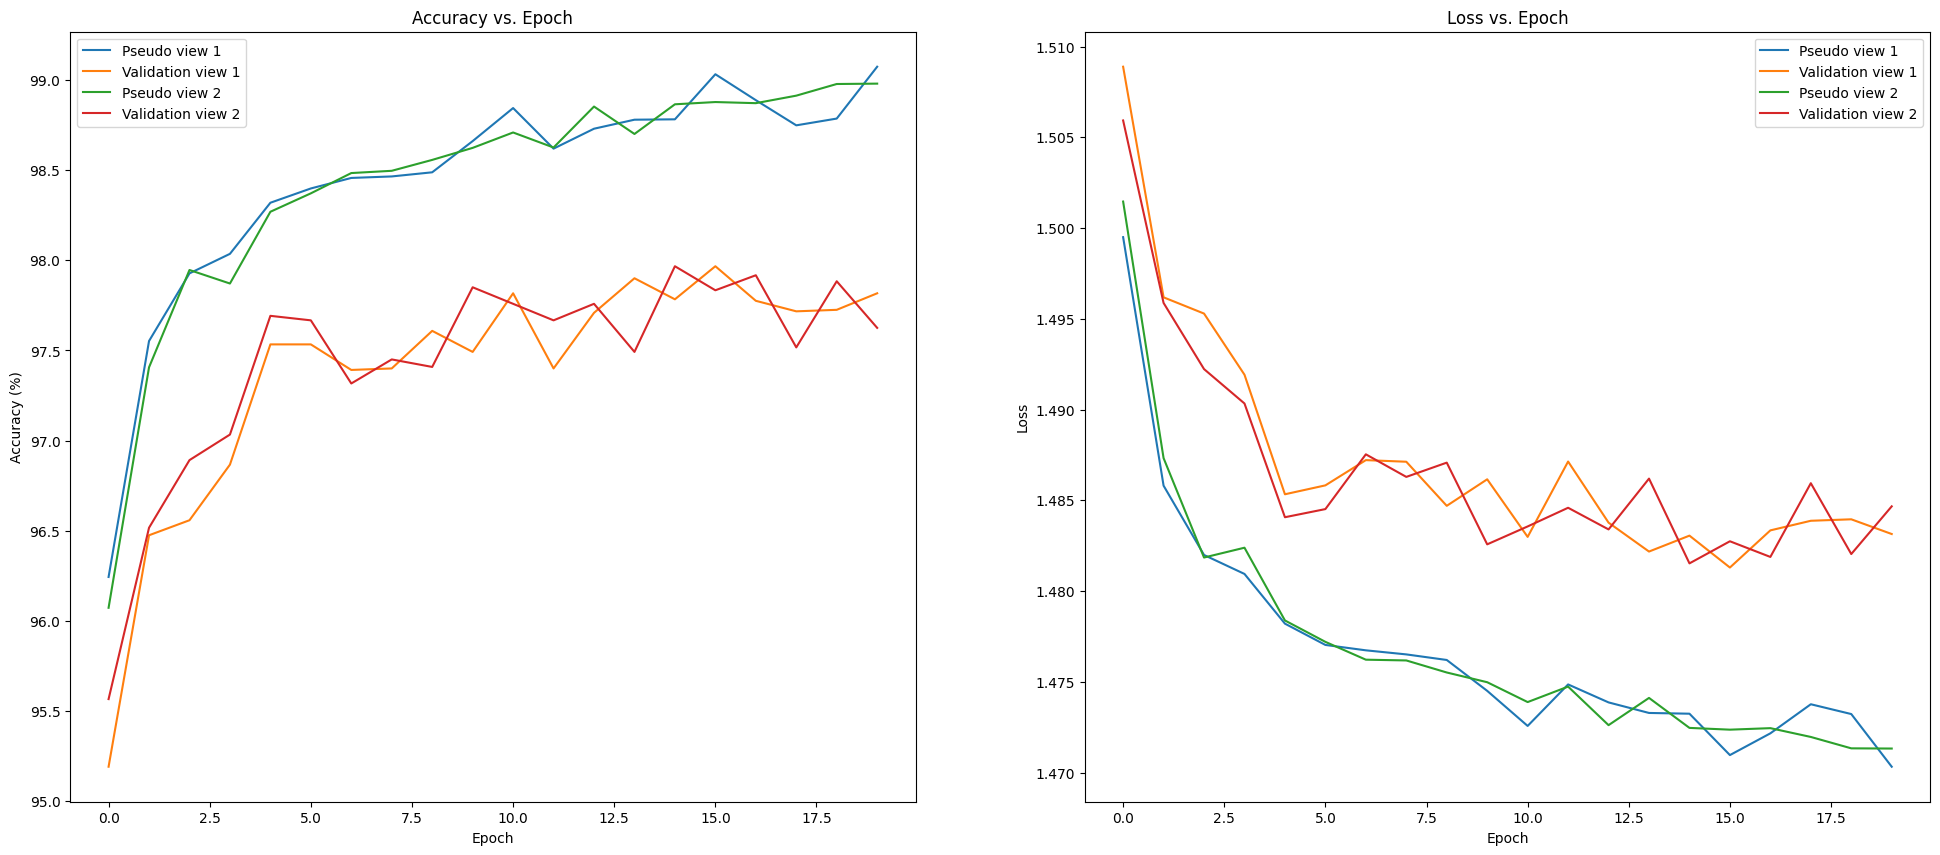

In [ ]:
plot_co_model(results)

In [ ]:
torch.save(model_net1.state_dict(), 'model_1.pth')
torch.save(model_net2.state_dict(), 'model_2.pth')

# Висновок


У цій роботі ми досліджували концепцію напівконтрольованого навчання, потужного підходу до машинного навчання, який використовує як позначені, так і немарковані дані для навчання моделі. Ми використали просту репрезентативну модель і навчили її за допомогою co-train алгоритму з використанням позначених і не позначених даних.

Аналіз результатів показав, що при навчанні на повному наборі даних модель показала точність в 98.46%, а при напівконтролюованому навчанні точність в 97.82%.
Порівняння методів простого навчання та спільного навчання підкреслює фундаментальну різницю у використанні даних для модельного навчання.

Просте навчання спирається виключно на позначені дані, обмежуючи вплив моделі на вузький набір інформації. Цей підхід може призвести до моделей, які важко узагальнити та можуть бути схильні до переобладнання через обмежений набір даних.

З іншого боку, Co-Training представляє більш складний підхід, використовуючи як позначені, так і немарковані дані. Ця техніка використовує велику кількість немаркованих даних, генеруючи псевдомітки та пропонуючи кілька точок зору або поглядів для навчання моделі. Спільне навчання часто призводить до покращення узагальнення та ефективності, збагачуючи процес навчання більш різноманітним набором даних.

Зрештою, вибір між простим навчанням і спільним навчанням залежить від наявності позначених даних і бажаної продуктивності моделі. Здатність Co-Training ефективніше використовувати наявні дані часто призводить до кращого узагальнення, що робить його цінною стратегією в контекстах напівконтрольованого навчання, де позначені дані є дефіцитними.